In [1]:
import matplotlib.pyplot as plt
from math import ceil,log,exp,sqrt
import numpy as np
import statistics
import scipy.stats as stats
import torch

In [2]:
path = "/home/daqop/mountpoint_snellius/binding_data/BA_pMHCI.csv";

with open(path, "r") as f:
    ln = 0
    human_rows = []
    non_human_rows = []
    for line in f:
        row = line.replace("\n", "").split(",");
        if ln > 0:
            allele = row[1];
            peptide = row[2]
            ba_value = float(row[3]);
            if len(peptide) == 9 and ba_value > 1: ## common filter
                ##check if allele is human:
                if allele == "HLA-A*02:01":
                    human_rows.append(row);
                else:
                    non_human_rows.append(row);
        ln+=1

## make the dict
h_ba_data = {
    "Positive": [],
    "Negative": []
}
## get the positive rows
for entry in human_rows:
    if float(entry[3]) < 500:
        h_ba_data["Positive"].append(entry);
    else:
        h_ba_data["Negative"].append(entry)
print(f"Positive binding affinity for humans: {len(h_ba_data['Positive'])}");
print(f"Negative binding affinity for humans: {len(h_ba_data['Negative'])}");
print(f"Total number of binding affinity:{len(h_ba_data['Positive']) + len(h_ba_data['Negative'])}");

Positive binding affinity for humans: 3511
Negative binding affinity for humans: 4214
Total number of binding affinity:7725


In [ ]:
## build the training, test and benchmark datasets:
dataset_len = len(h_ba_data["Positive"])
training = h_ba_data["Positive"][0:0.8]

Create the histogram for the distribution of BA:

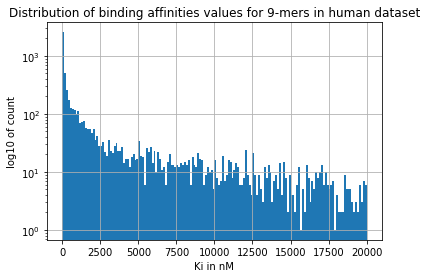

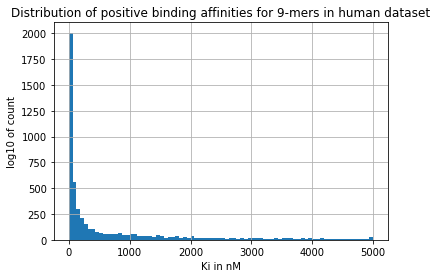

In [3]:
affinities = [float(entry[3]) for entry in human_rows];
plt.hist(affinities, bins=160, log=True, range=(0,20000) )
plt.title("Distribution of binding affinities values for 9-mers in human dataset")
plt.xlabel("Ki in nM")
plt.ylabel("log10 of count")
plt.grid(True)
plt.show()

plt.hist(affinities, bins=80, range=(0,5000))
plt.title("Distribution of positive binding affinities for 9-mers in human dataset")
plt.xlabel("Ki in nM")
plt.ylabel("log10 of count")
plt.grid(True)
plt.show()

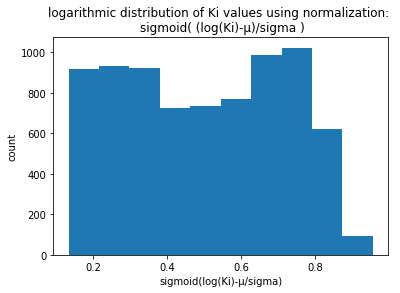

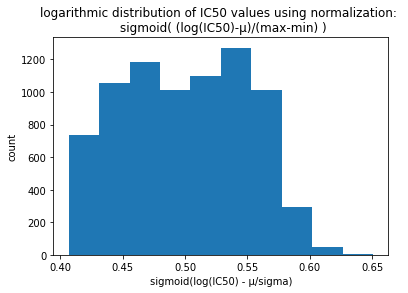

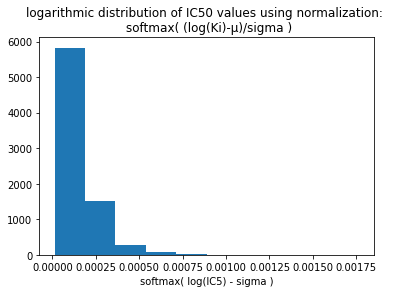

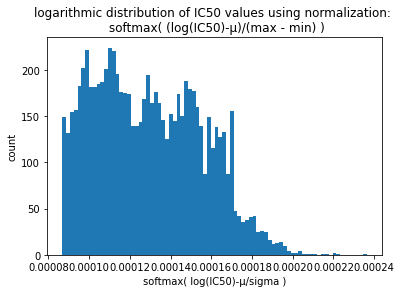

In [11]:
# play with data: look for how to log them, sigmoid:
t_affinities = torch.Tensor([log(affinity) for affinity in affinities])
mean = t_affinities.mean();
sigma = t_affinities.std();
#z_affinities = (affinities - mean)/(affinities.max() - affinities.min())
z_affinities = (t_affinities - mean)/sigma
z_affinities = torch.sigmoid(z_affinities)

## first plot
plt.hist([float(i) for i in z_affinities], bins=10)
plt.title("logarithmic distribution of Ki values using normalization: \n sigmoid( (log(Ki)-µ)/sigma )")
plt.xlabel("sigmoid(log(Ki)-µ/sigma)")
plt.ylabel("count")
plt.show()

## second plot
z_affinities = (t_affinities - mean)/(t_affinities.max() - t_affinities.min())
z_affinities = torch.sigmoid(z_affinities)
plt.hist([float(i) for i in z_affinities], bins=10)
plt.title("logarithmic distribution of IC50 values using normalization: \n sigmoid( (log(IC50)-µ)/(max-min) )")
plt.xlabel("sigmoid(log(IC50) - µ/sigma)")
plt.ylabel("count")
plt.show()

## third plot
z_affinities = (t_affinities - mean)/(sigma)
sm = torch.nn.Softmax(dim = 0);
z_affinities = sm(z_affinities);
plt.hist([float(i) for i in z_affinities], bins=10)
plt.title("logarithmic distribution of IC50 values using normalization: \n softmax( (log(Ki)-µ)/sigma )")
plt.xlabel("softmax( log(IC5) - sigma )")
plt.show()

## fourth plot
z_affinities = (t_affinities - mean)/(t_affinities.max() - t_affinities.min())
sm = torch.nn.Softmax(dim = 0);
z_affinities = sm(z_affinities);
plt.hist([float(i) for i in z_affinities], bins=80)
plt.title("logarithmic distribution of IC50 values using normalization: \n softmax( (log(IC50)-µ)/(max - min) )")
plt.xlabel("softmax( log(IC50)-µ/sigma )")
plt.ylabel("count")
plt.show()


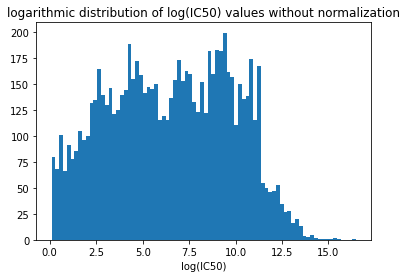

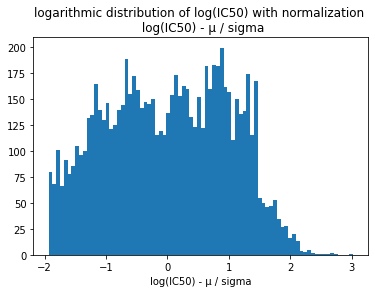

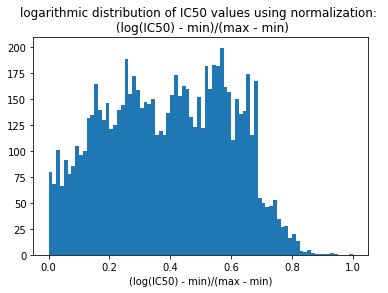

In [6]:
# here we look at the normal distribution:
##fifth plot
z_affinities = (t_affinities)
plt.hist([float(i) for i in z_affinities], bins=80)
plt.title("logarithmic distribution of log(IC50) values without normalization")
plt.xlabel("log(IC50)")
plt.show()

##sixth plot
z_affinities = ((t_affinities - mean)/sigma)
plt.hist([float(i) for i in z_affinities], bins=80)
plt.title("logarithmic distribution of log(IC50) with normalization \n log(IC50) - µ / sigma")
plt.xlabel("log(IC50) - µ / sigma")
plt.show()

##seventh plot
z_affinities = (t_affinities - t_affinities.min())/(t_affinities.max() - t_affinities.min())
plt.hist([float(i) for i in z_affinities], bins=80)
plt.title("logarithmic distribution of IC50 values using normalization: \n (log(IC50) - min)/(max - min)")
plt.xlabel("(log(IC50) - min)/(max - min)")
plt.show()

for each alleles, count the numbers of positive and negative

In [7]:
unique_h_allele = set([entry[1] for entry in human_rows])
h_allele_dis = {}
for allele in unique_h_allele:
    positive_entries = len([entry for entry in human_rows if entry[1] == allele and entry[4] == "Positive"]);
    negative_entries = len([entry for entry in human_rows if entry[1] == allele and entry[4] == "Negative"]);
    # if (positive_entries > 1000):
    h_allele_dis[allele] = {
        "p": positive_entries,
        "n": negative_entries
    };
print(len(unique_h_allele))

1


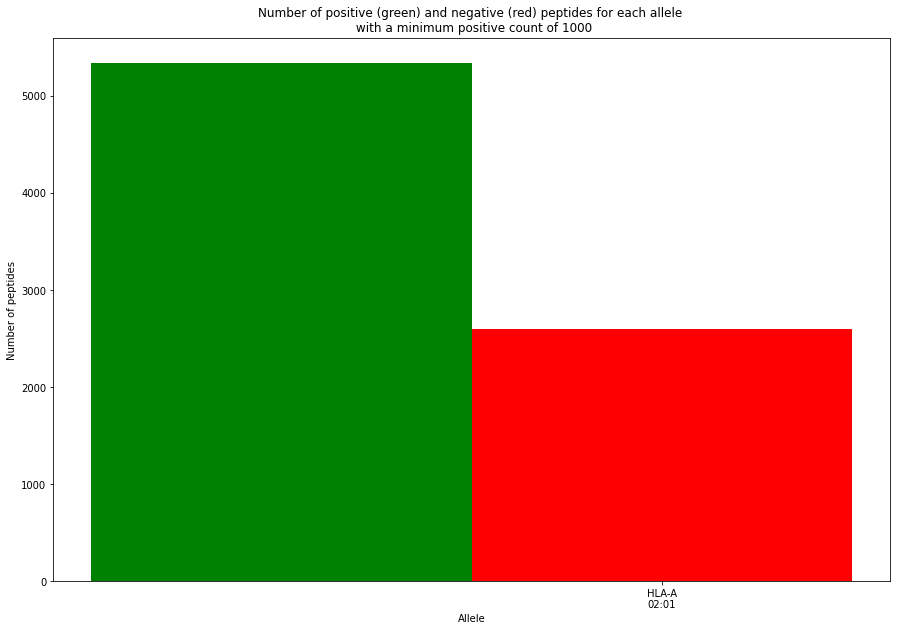

In [8]:
values = [];
labels = [];
barWidth = 0.25
positions = [];
i = 0
for key,value in h_allele_dis.items():
    values.append([value["p"], value["n"]]);
    labels.append(key.replace("*", "\n"))
    pos_array = [i,i+barWidth];
    positions.append(pos_array)
    i+=1
plt.figure(figsize=(15,10))
for i in range(len(labels)):
    plt.bar(positions[i], values[i], width=barWidth, color=["green", "red"])
plt.ylabel("Number of peptides")
plt.xlabel("Allele")
plt.title("Number of positive (green) and negative (red) peptides for each allele \n with a minimum positive count of 1000")
plt.xticks([r + barWidth for r in range(len(labels))], labels)
plt.show()

In [9]:
#generate the CSV file
rows = "\n".join([",".join(entry) for entry in human_rows]);
path = "../binding_data/mchI_quantitative_human_9_mers.csv"
with open(path, "w") as f:
    f.write(rows);